In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import time
import torch
import torchmetrics
import torchvision
from torchvision import transforms
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import numpy as np
from torch.utils.data import random_split
from torch.autograd import Variable
from matplotlib import pyplot as plt
import pandas as pd




#Make sure we are running on the
print(torch.cuda.is_available())
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(torch.cuda.get_device_name(cuda_id))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
Tesla T4
cuda


# Problem 1

## Load FashionMNIST Dataset

In [ ]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform= torchvision.transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform= torchvision.transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
batch_size = 64

#Split the training to train and val
val_split = 0.1
dataset_size = int(len(trainset)*val_split)

trainset, validationset = random_split(trainset, [len(trainset)-dataset_size, dataset_size])


# Create the data loaders
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(trainset, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle = False)

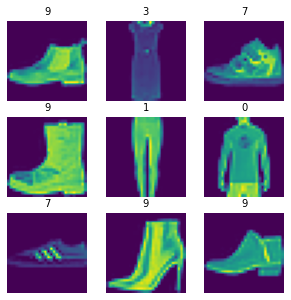

In [ ]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

fig, axs = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i][0])
    ax.set_title(labels[i].item(), fontsize=10)
    ax.axis('off')

plt.show()

## Define Training Loop

In [ ]:
#define training fucntion
def train(MLP, train_loader, val_loader, num_epochs, optimizer, criterion):
  count = 0
  for epoch in range(num_epochs):
      for images, labels in train_loader:
          MLP.train()

          # Convert images and labels to PyTorch variables
          #images = images.view(images.size(0), -1)
          #images, labels = Variable(images), Variable(labels)

          # Forward pass 
          outputs = MLP(images)
          labels = torch.eye(10)[labels]
          train_loss = criterion(outputs, labels)

          # Initializing a gradient as 0 so there is no mixing of gradient among the batches
          optimizer.zero_grad()    
          # Propagating the error backward
          train_loss.backward()
          # Optimizing the parameters
          optimizer.step()

          # calculate the accuracy
          accuracy.update(outputs, labels)
          
      final_accuracy_train = accuracy.compute()         
      train_accuracy_list.append(final_accuracy_train)
      train_loss_list.append(train_loss)
      # get the final accuracy  
      #accuracy.reset()

      for images, labels in val_loader:
          MLP.eval()
          # Convert images and labels to PyTorch variables
          #images = images.view(images.size(0), -1)
          #images, labels = Variable(images), Variable(labels)
          labels = torch.eye(10)[labels]
          # Forward pass 
          with torch.no_grad():
            outputs = MLP(images)
          loss_val = criterion(outputs, labels)

          #calculate the accuracy
          accuracy.update(outputs, labels)

      final_accuracy_val = accuracy.compute()    
      val_accuracy_list.append(final_accuracy_val)
      val_loss_list.append(loss_val)
      print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss}, Train Acc: {final_accuracy_train}, ValidationLoss: {loss_val}, Validation Acc: {final_accuracy_val}')     
      accuracy.reset()

## Problem 1a

*1.a. train the model from scratch (with randomized parameters) and plot the results(training loss and accuracy, validation accuracy) after 20 epochs. Does your network need more epochs for full training? Do you observe overfitting? Make sure to save the trained parameters and model. *
> The Plots of the Accuracies and Loss can be seen in the code below.
It does seem like the netwrok needs more epochs for full training as it has not completely converged at the end of the 20 epochs. The model does not seem to be overfitting as the accuracies of the training and the validation increase and are both almost the same.



In [ ]:
#build model
MLP = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 500),
    nn.ReLU(),
    nn.Linear(500, 300),
    nn.ReLU(),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

print(MLP)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=500, bias=True)
  (2): ReLU()
  (3): Linear(in_features=500, out_features=300, bias=True)
  (4): ReLU()
  (5): Linear(in_features=300, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
#define params
num_epochs = 20
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MLP.parameters(), lr = 1e-4)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
train(MLP, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/20], Loss: 0.46671849489212036, Train Acc: 0.6237151622772217, ValidationLoss: 0.5023583769798279, Validation Acc: 0.6254938244819641
Epoch [2/20], Loss: 0.4748041033744812, Train Acc: 0.6331207156181335, ValidationLoss: 0.2776641547679901, Validation Acc: 0.6349805593490601
Epoch [3/20], Loss: 0.7614194750785828, Train Acc: 0.647034764289856, ValidationLoss: 0.19997303187847137, Validation Acc: 0.6541860699653625
Epoch [4/20], Loss: 0.4078653156757355, Train Acc: 0.6583287715911865, ValidationLoss: 0.41452401876449585, Validation Acc: 0.6611385345458984
Epoch [5/20], Loss: 0.23538286983966827, Train Acc: 0.6695358753204346, ValidationLoss: 0.26765453815460205, Validation Acc: 0.6748605370521545
Epoch [6/20], Loss: 0.15729926526546478, Train Acc: 0.6804457902908325, ValidationLoss: 0.173629492521286, Validation Acc: 0.6865889430046082
Epoch [7/20], Loss: 0.1608595997095108, Train Acc: 0.6901646256446838, ValidationLoss: 0.19541776180267334, Validation Acc: 0.6937620043754578
E

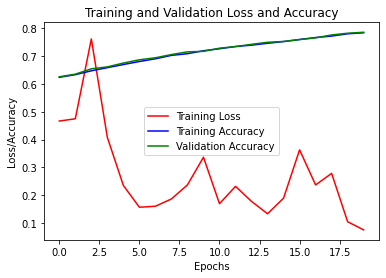

In [ ]:
Trainlosses= [ loss.detach().numpy() for loss in train_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

In [ ]:
# Save model
PATH = "/content/drive/MyDrive/Real Time ML/model.pt"
torch.save(MLP.state_dict(), PATH)

## Probelm 1b - Add weight decay to 1a

**1.b Report section a; this time add weight penalties (weight decays). Report and plot your training results. how do the training results change compared to the baseline?**
> The Plots of the Accuracies and Loss can be seen in the code below. As compared to the base line, an increase in accuracy can be seen although the number of training epochs remained the same.



In [ ]:
#define params
num_epochs = 20
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MLP.parameters(), lr = 1e-4, weight_decay = 0.0001)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
#reset model
# Reset the model's weights
def reset_weights(m):
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

MLP.apply(reset_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=500, bias=True)
  (2): ReLU()
  (3): Linear(in_features=500, out_features=300, bias=True)
  (4): ReLU()
  (5): Linear(in_features=300, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
train(MLP, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/20], Loss: 0.3615134358406067, Train Acc: 0.6421513557434082, ValidationLoss: 0.28198862075805664, Validation Acc: 0.6529286503791809
Epoch [2/20], Loss: 0.41932573914527893, Train Acc: 0.6575354337692261, ValidationLoss: 0.7177096009254456, Validation Acc: 0.6620004773139954
Epoch [3/20], Loss: 0.39067524671554565, Train Acc: 0.6665843725204468, ValidationLoss: 0.6615552306175232, Validation Acc: 0.6755852699279785
Epoch [4/20], Loss: 0.30488333106040955, Train Acc: 0.6830612421035767, ValidationLoss: 0.5729907751083374, Validation Acc: 0.6874783039093018
Epoch [5/20], Loss: 0.30873140692710876, Train Acc: 0.6956172585487366, ValidationLoss: 0.38087198138237, Validation Acc: 0.6984407901763916
Epoch [6/20], Loss: 0.33598995208740234, Train Acc: 0.7080270051956177, ValidationLoss: 0.22018052637577057, Validation Acc: 0.7048171162605286
Epoch [7/20], Loss: 0.4345983564853668, Train Acc: 0.7200685739517212, ValidationLoss: 0.1801590919494629, Validation Acc: 0.7205555438995361
E

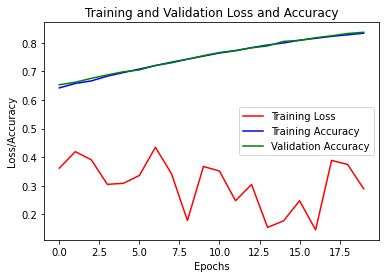

In [ ]:
Trainlosses= [ loss.detach().numpy() for loss in train_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

## Problem 1c - Add Dropout to 1a

**1.c Report section a; this time add dropout (dropout = 0.3). Report and plot your training results. how do the training results change compared to the baseline? How the training results change compared to the weight penalties.**
> The Plots of the Accuracies and Loss can be seen in the code below. As compared to the base line, an increase in accuracy can be seen although the number of training epochs remained the same. As compared to 1b where weight penalties were added, there was also an increase in the accuracy and so dropout performed better.




In [ ]:
#build model
MLP = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 500),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(500, 300),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(100, 10)
)

In [ ]:
#define params
num_epochs = 20
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MLP.parameters(), lr = 1e-4)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
#reset model
# Reset the model's weights
def reset_weights(m):
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

MLP.apply(reset_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=500, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=500, out_features=300, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.3, inplace=False)
  (7): Linear(in_features=300, out_features=100, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.3, inplace=False)
  (10): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
train(MLP, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/20], Loss: 0.5236297845840454, Train Acc: 0.6921284794807434, ValidationLoss: 0.32056283950805664, Validation Acc: 0.722432553768158
Epoch [2/20], Loss: 0.9185923337936401, Train Acc: 0.7605350017547607, ValidationLoss: 0.5803247690200806, Validation Acc: 0.7716209292411804
Epoch [3/20], Loss: 0.6375334858894348, Train Acc: 0.7847805023193359, ValidationLoss: 0.32032036781311035, Validation Acc: 0.7922393679618835
Epoch [4/20], Loss: 0.37597131729125977, Train Acc: 0.8010059595108032, ValidationLoss: 0.2791551947593689, Validation Acc: 0.8072153925895691
Epoch [5/20], Loss: 0.1323983073234558, Train Acc: 0.8114243149757385, ValidationLoss: 0.2667083144187927, Validation Acc: 0.8156081438064575
Epoch [6/20], Loss: 0.5591331124305725, Train Acc: 0.8215820789337158, ValidationLoss: 0.3099946677684784, Validation Acc: 0.8272896409034729
Epoch [7/20], Loss: 0.29004502296447754, Train Acc: 0.8295198678970337, ValidationLoss: 0.15431854128837585, Validation Acc: 0.8312219977378845
Ep

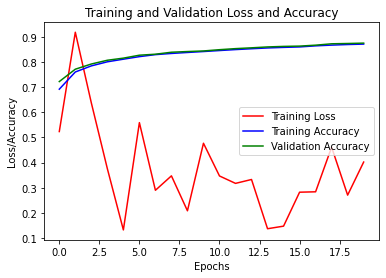

In [ ]:
Trainlosses= [ loss.detach().numpy() for loss in train_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

## Problem 1d - Transfer Learning Using 1a Params With Weight Decay

**repeat problems 1.b and 1.c; this time, load the pre-trained parameters from the storage. Plot the training results, and compare the training time and number of epochs needed against 1.b and 1.c.**
> The Plots of the Accuracies and Loss can be seen in the code below. The training time took less as the parameters were already initialized. There does not seem to be a need for extra trainign epochs as the accuracies converge by the end of the 20 epochs.



In [ ]:
#reset model
# Reset the model's weights
def reset_weights(m):
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

MLP.apply(reset_weights)

In [ ]:
#define model
#build model
MLP = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 500),
    nn.ReLU(),
    nn.Linear(500, 300),
    nn.ReLU(),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

print(MLP)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=500, bias=True)
  (2): ReLU()
  (3): Linear(in_features=500, out_features=300, bias=True)
  (4): ReLU()
  (5): Linear(in_features=300, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
# Load pre-trained model parameters
state_dict = torch.load('/content/drive/MyDrive/Real Time ML/model.pt')

# Load the model parameters
MLP.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
#define params
num_epochs = 20
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MLP.parameters(), lr = 1e-4, weight_decay = 0.0001)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
train(MLP, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/20], Loss: 0.039441291242837906, Train Acc: 0.7850907444953918, ValidationLoss: 0.29564061760902405, Validation Acc: 0.7824286818504333
Epoch [2/20], Loss: 0.16231505572795868, Train Acc: 0.7856277823448181, ValidationLoss: 0.17317311465740204, Validation Acc: 0.7864657640457153
Epoch [3/20], Loss: 0.24237008392810822, Train Acc: 0.7925592660903931, ValidationLoss: 0.14874933660030365, Validation Acc: 0.7933861017227173
Epoch [4/20], Loss: 0.3792783319950104, Train Acc: 0.7961296439170837, ValidationLoss: 0.11995477229356766, Validation Acc: 0.7951546311378479
Epoch [5/20], Loss: 0.053625453263521194, Train Acc: 0.8007314801216125, ValidationLoss: 0.1394190639257431, Validation Acc: 0.80063796043396
Epoch [6/20], Loss: 0.08291468769311905, Train Acc: 0.8070759177207947, ValidationLoss: 0.3161780536174774, Validation Acc: 0.8050333261489868
Epoch [7/20], Loss: 0.27448251843452454, Train Acc: 0.8123907446861267, ValidationLoss: 0.09392756223678589, Validation Acc: 0.810639798641

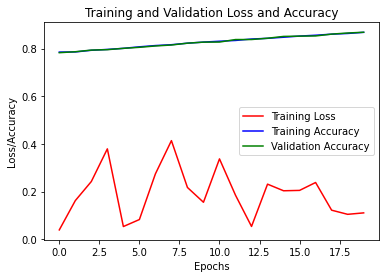

In [ ]:
Trainlosses= [ loss.detach().numpy() for loss in train_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

## Problem 1d - Transfer Learning Using 1a Params With Dropout

In [ ]:
#reset model
# Reset the model's weights
def reset_weights(m):
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

MLP.apply(reset_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=500, bias=True)
  (2): ReLU()
  (3): Linear(in_features=500, out_features=300, bias=True)
  (4): ReLU()
  (5): Linear(in_features=300, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
# Load pre-trained model parameters
state_dict = torch.load('/content/drive/MyDrive/Real Time ML/model.pt')

# Load the model parameters
MLP.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
MLP.insert(4, nn.Dropout(0.3))

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=500, bias=True)
  (2): ReLU()
  (3): Linear(in_features=500, out_features=300, bias=True)
  (4): Dropout(p=0.3, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=300, out_features=100, bias=True)
  (7): ReLU()
  (8): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
#define params
num_epochs = 20
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MLP.parameters(), lr = 1e-4)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
train(MLP, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/20], Loss: 0.36882734298706055, Train Acc: 0.795544445514679, ValidationLoss: 0.27196601033210754, Validation Acc: 0.7986462712287903
Epoch [2/20], Loss: 0.11069818586111069, Train Acc: 0.806257426738739, ValidationLoss: 0.23657192289829254, Validation Acc: 0.8102953433990479
Epoch [3/20], Loss: 0.28307369351387024, Train Acc: 0.8136351704597473, ValidationLoss: 0.3188953697681427, Validation Acc: 0.819337010383606
Epoch [4/20], Loss: 0.22845669090747833, Train Acc: 0.8222647905349731, ValidationLoss: 0.2055039256811142, Validation Acc: 0.8236324191093445
Epoch [5/20], Loss: 0.266293466091156, Train Acc: 0.8274685144424438, ValidationLoss: 0.13457606732845306, Validation Acc: 0.8282712697982788
Epoch [6/20], Loss: 0.20538048446178436, Train Acc: 0.8329185247421265, ValidationLoss: 0.19720937311649323, Validation Acc: 0.8345500230789185
Epoch [7/20], Loss: 0.28740963339805603, Train Acc: 0.839379608631134, ValidationLoss: 0.15006762742996216, Validation Acc: 0.8383490443229675


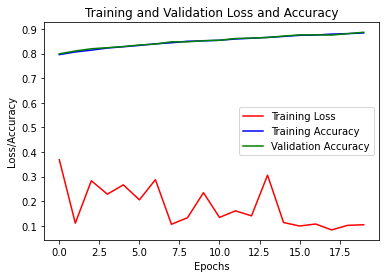

In [ ]:
Trainlosses= [ loss.detach().numpy() for loss in train_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

# Problem 2

**2.a What happens if we need to standardize the continuous numerical features like what we have done in this section?**
> Standarizing the continous numerical values is important when the range of values for the different features is different. When this is the case features with higher numerical values will have a stronger bias on the model and much higher weights. Normalizing the data sets it between -1 and 1 and makes the range equal between the features and thus the bias of each feature is the same




### Define Classes

In [5]:
def preprocess():
        # Remove the ID and label columns
        label = 'SalePrice'
        features = pd.concat(
            (raw_train.drop(columns=['Id', label]),
             raw_val.drop(columns=['Id'])))
        # Standardize numerical columns
        numeric_features = features.dtypes[features.dtypes != 'object'].index
        features[numeric_features] = features[numeric_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        # Replace NAN numerical features by 0
        features[numeric_features] = features[numeric_features].fillna(0)
        # Replace discrete features by one-hot encoding.
        features = pd.get_dummies(features, dummy_na=True)
        # Save preprocessed features
        train = features[:raw_train.shape[0]].copy()
        train[label] = raw_train[label]
        val = features[raw_train.shape[0]:].copy()

In [24]:
#define training fucntion
def train(model, train_loader, val_loader, num_epochs, optimizer, criterion):
  count = 0
  for epoch in range(num_epochs):
      for x, y in train_loader:
          model.train()

          # Convert tensors to the correct datatype
          x = x.float()
          y = y.float().view(-1, 1)

          # Forward pass 
          outputs = model(x)
          train_loss = criterion(outputs, y)

          # Initializing a gradient as 0 so there is no mixing of gradient among the batches
          optimizer.zero_grad()    
          # Propagating the error backward
          train_loss.backward()
          # Optimizing the parameters
          optimizer.step()

      train_loss_list.append(train_loss)

      for x, y in val_loader:
          model.eval()
    
          # Convert tensors to the correct datatype
          x = x.float()
          y = y.float().view(-1, 1)

          # Forward pass 
          with torch.no_grad():
            outputs = MLP(x)
          loss_val = criterion(outputs, y)

      val_loss_list.append(loss_val)
      print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss}, ValidationLoss: {loss_val}')     


In [25]:
#textbook's Linear Regression function with 3 hidden layers instead of three
class LinearRegressionModel(nn.Module):
    def __init__(self, lr):
        super().__init__()
        self.lin1 = nn.LazyLinear(1, 256)
        self.lin2 = nn.LazyLinear(256, 128)
        self.lin3 = nn.LazyLinear(128, 1)
        self.lin1.weight.data.normal_(0, 0.01)
        self.lin1.bias.data.fill_(0)
        self.lin2.weight.data.normal_(0, 0.01)
        self.lin2.bias.data.fill_(0)
        self.lin3.weight.data.normal_(0, 0.01)
        self.lin3.bias.data.fill_(0)

    def forward(self, x):
        x = x.view(-1, 1)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

### Data

In [16]:
class Data:
    def __init__(self):
        self.raw_train = pd.read_csv('/content/drive/MyDrive/Real Time ML/train.csv')
        self.raw_val = pd.read_csv('/content/drive/MyDrive/Real Time ML/test.csv')

    def preprocess(self):
        # Remove the ID and label columns
        label = 'SalePrice'
        features = pd.concat(
            (self.raw_train.drop(columns=['Id', label]),
            self.raw_val.drop(columns=['Id'])))
        # Standardize numerical columns
        numeric_features = features.dtypes[features.dtypes != 'object'].index
        features[numeric_features] = features[numeric_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        # Replace NAN numerical features by 0
        features[numeric_features] = features[numeric_features].fillna(0)
        # Replace discrete features by one-hot encoding.
        features = pd.get_dummies(features, dummy_na=True)
        # Save preprocessed features
        self.train = features[:self.raw_train.shape[0]].copy()
        self.train[label] = self.raw_train[label]
        self.val = features[self.raw_train.shape[0]:].copy()

data = Data()

In [10]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [21]:
data.preprocess()
print(data.train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   MSSubClass  LotFrontage   LotArea  OverallQual  SaleCondition_Partial  \
0    0.067320    -0.184443 -0.217841     0.646073                      0   
1   -0.873466     0.458096 -0.072032    -0.063174                      0   
2    0.067320    -0.055935  0.137173     0.646073                      0   
3    0.302516    -0.398622 -0.078371     0.646073                      0   

   SaleCondition_nan  SalePrice  
0                  0     208500  
1                  0     181500  
2                  0     223500  
3                  0     140000  


In [29]:
import torch
from torch.utils.data import Dataset, DataLoader

class KaggleHouseDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

train_dataset = KaggleHouseDataset(data.train)
val_dataset = KaggleHouseDataset(data.val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

### Training

In [33]:
lr = 1e-4

#define params
num_epochs = 20
count = 0

#loss
model = LinearRegressionModel(lr)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


# Lists for visualization of loss and accuracy 
train_loss_list = []
val_loss_list = []

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [34]:
train(model, train_loader, val_loader, num_epochs, optimizer, loss)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([10592, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored